<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/tim-updates/notebooks-svc-feature-permutation-importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import joblib

import pandas as pd
import numpy as np

from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, ParameterGrid, cross_validate
from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
repo_path = '/content/drive/MyDrive/milestone-ii/'
train_path = ''.join([repo_path, 'Training_set.csv'])
test_path = ''.join([repo_path, 'Testing_set.csv'])

df_train = pd.read_csv(train_path, sep='\t', index_col='ix')
df_train['lemmatized_text'] = df_train['lemmatized_text'].fillna('')
df_test = pd.read_csv(test_path, sep='\t', index_col='ix')
df_test['lemmatized_text'] = df_test['lemmatized_text'].fillna('')

df = pd.concat([df_train, df_test])

In [5]:
readability_features = ['d_chall_score',	'aoa_mean',	'aoa_min',	'aoa_max',	
                        'conc_rating_mean',	'conc_rating_min',	'conc_rating_max', 'num_lemmas']

text_features = 'lemmatized_text'

all_features = readability_features + [text_features]

def build_clf(tfidf_kwargs={}, clf_kwargs={}, include_num_features=True):
  num_pipe = Pipeline([
      ('impute', SimpleImputer(strategy='mean')),
      ('scale', StandardScaler()),
      ('binner', KBinsDiscretizer(n_bins=4)),
  ])

  text_pipe = Pipeline([
      ('tfidf', TfidfVectorizer(**tfidf_kwargs)),
  ])

  if include_num_features:
    preprocessor = [('num', num_pipe, readability_features), 
                    ('text', text_pipe, text_features),]
  else:
    preprocessor = [('text', text_pipe, text_features)]

  preprocessor = ColumnTransformer(preprocessor)

  clf = Pipeline([
      ('preprocessor', preprocessor),
      ('clf', LinearSVC(**clf_kwargs))
  ])
  return clf

In [6]:
tfidf_kwargs=dict(max_df=.5, ngram_range=(1, 3))
clf_kwargs=dict(dual=False, C=.5, penalty='l1', random_state=99)

clf = build_clf(tfidf_kwargs=tfidf_kwargs, clf_kwargs=clf_kwargs, include_num_features=True)

In [7]:
clf = clf.fit(df_train, df_train.label)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [8]:
r = permutation_importance(clf, df_test[all_features], 
                           df_test.label, 
                           scoring='roc_auc', 
                           n_repeats=30, 
                           n_jobs=-1)

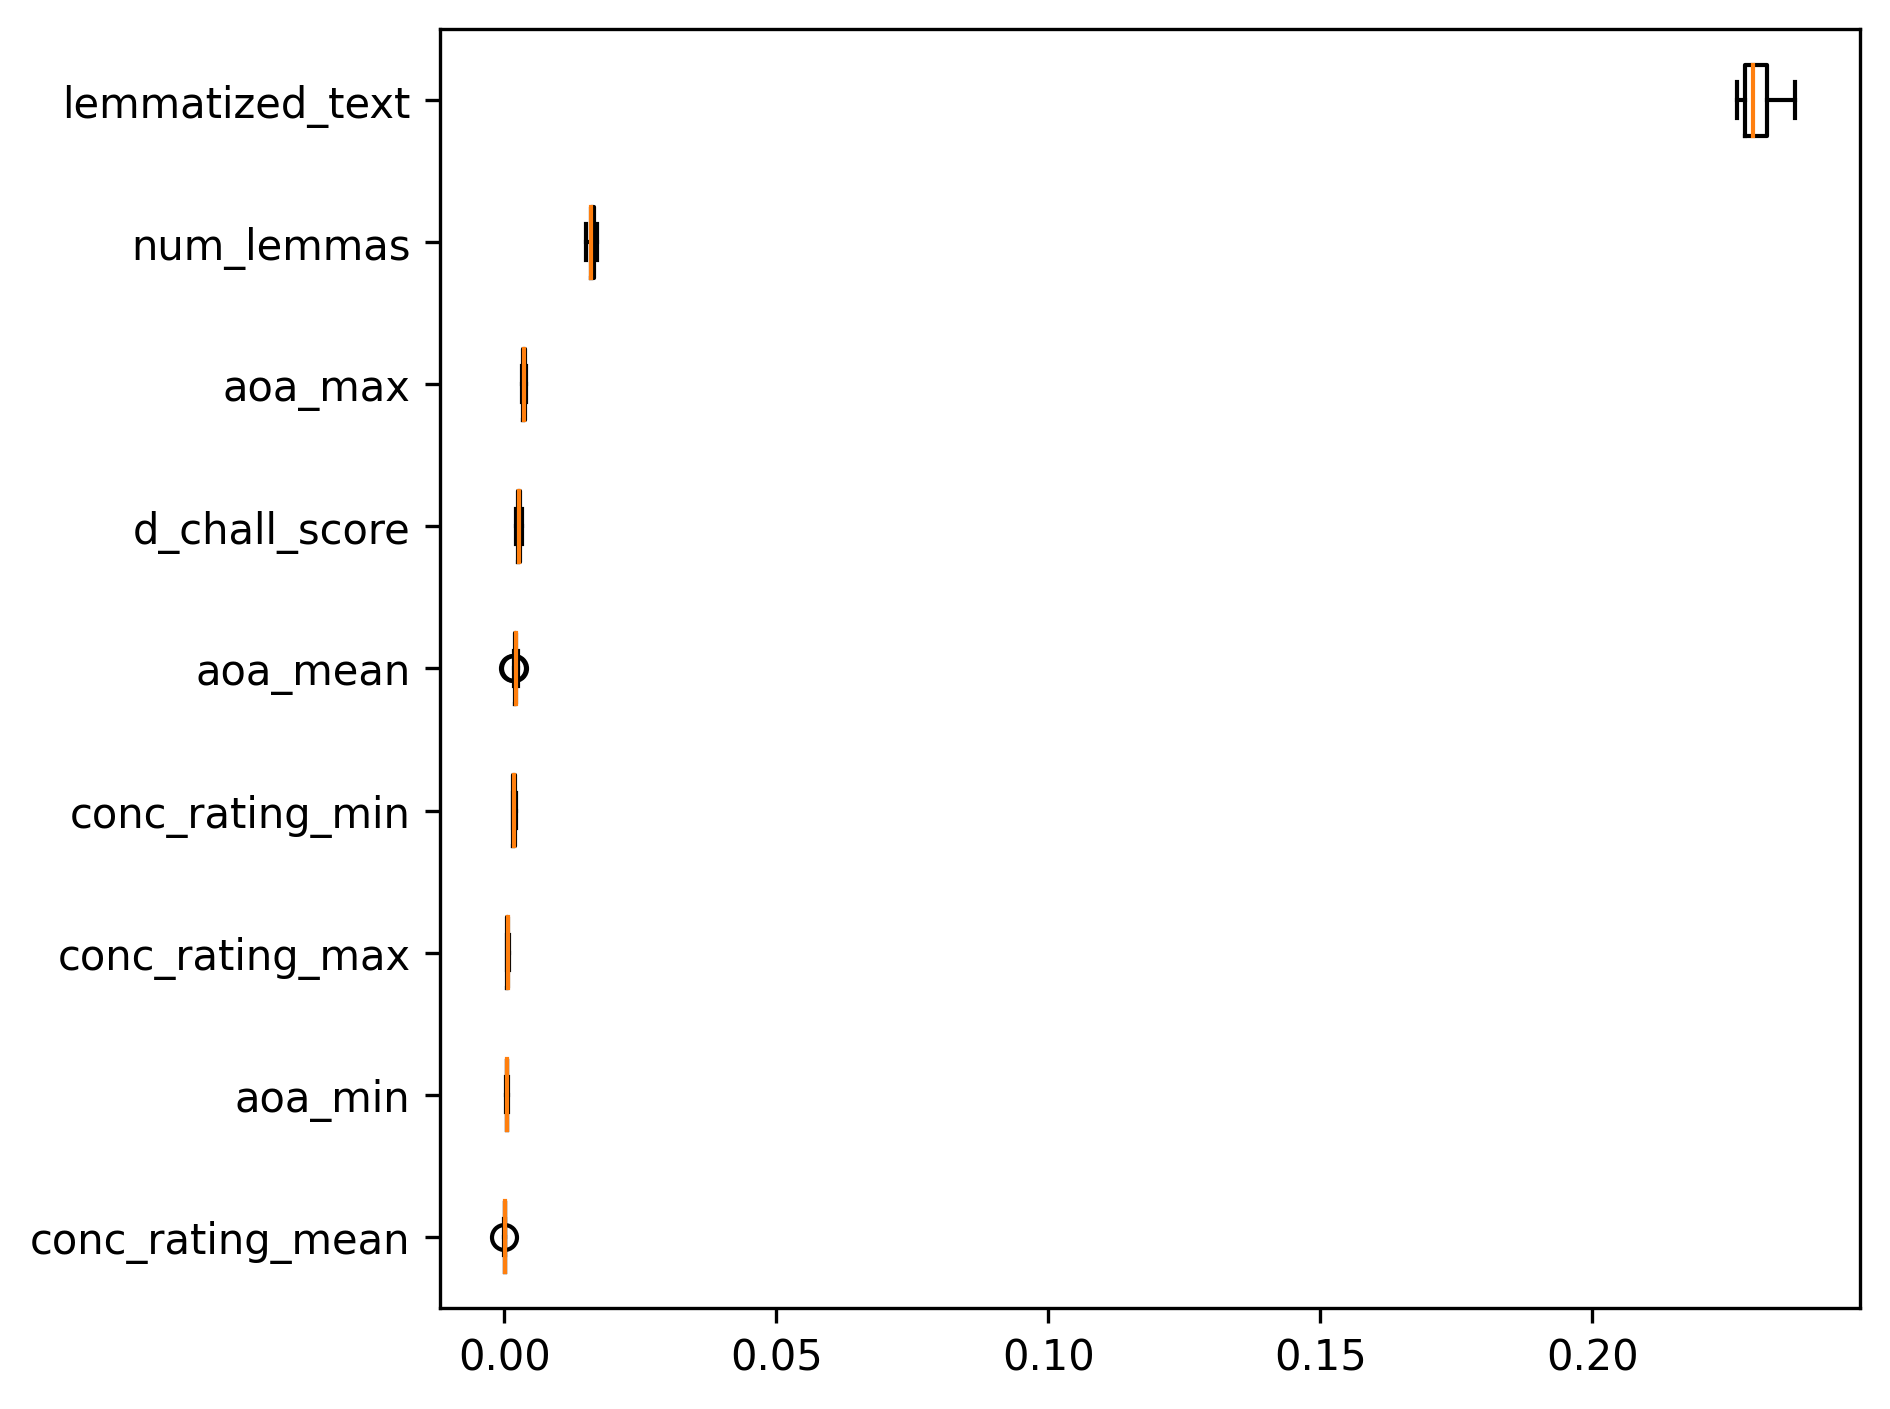

In [45]:
def plot_permutations(save=False):
  perm_sorted_idx = r.importances_mean.argsort()

  fig = plt.figure(dpi=300, figsize=(6.4, 4.8))
  ax = plt.gca()

  ax.boxplot(
    r.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(all_features)[perm_sorted_idx],
  )
  fig.tight_layout()
  if save:
    plt.savefig(''.join([repo_path, 'permutation-feature-analysis.png']), format='png')

plot_permutations(True)

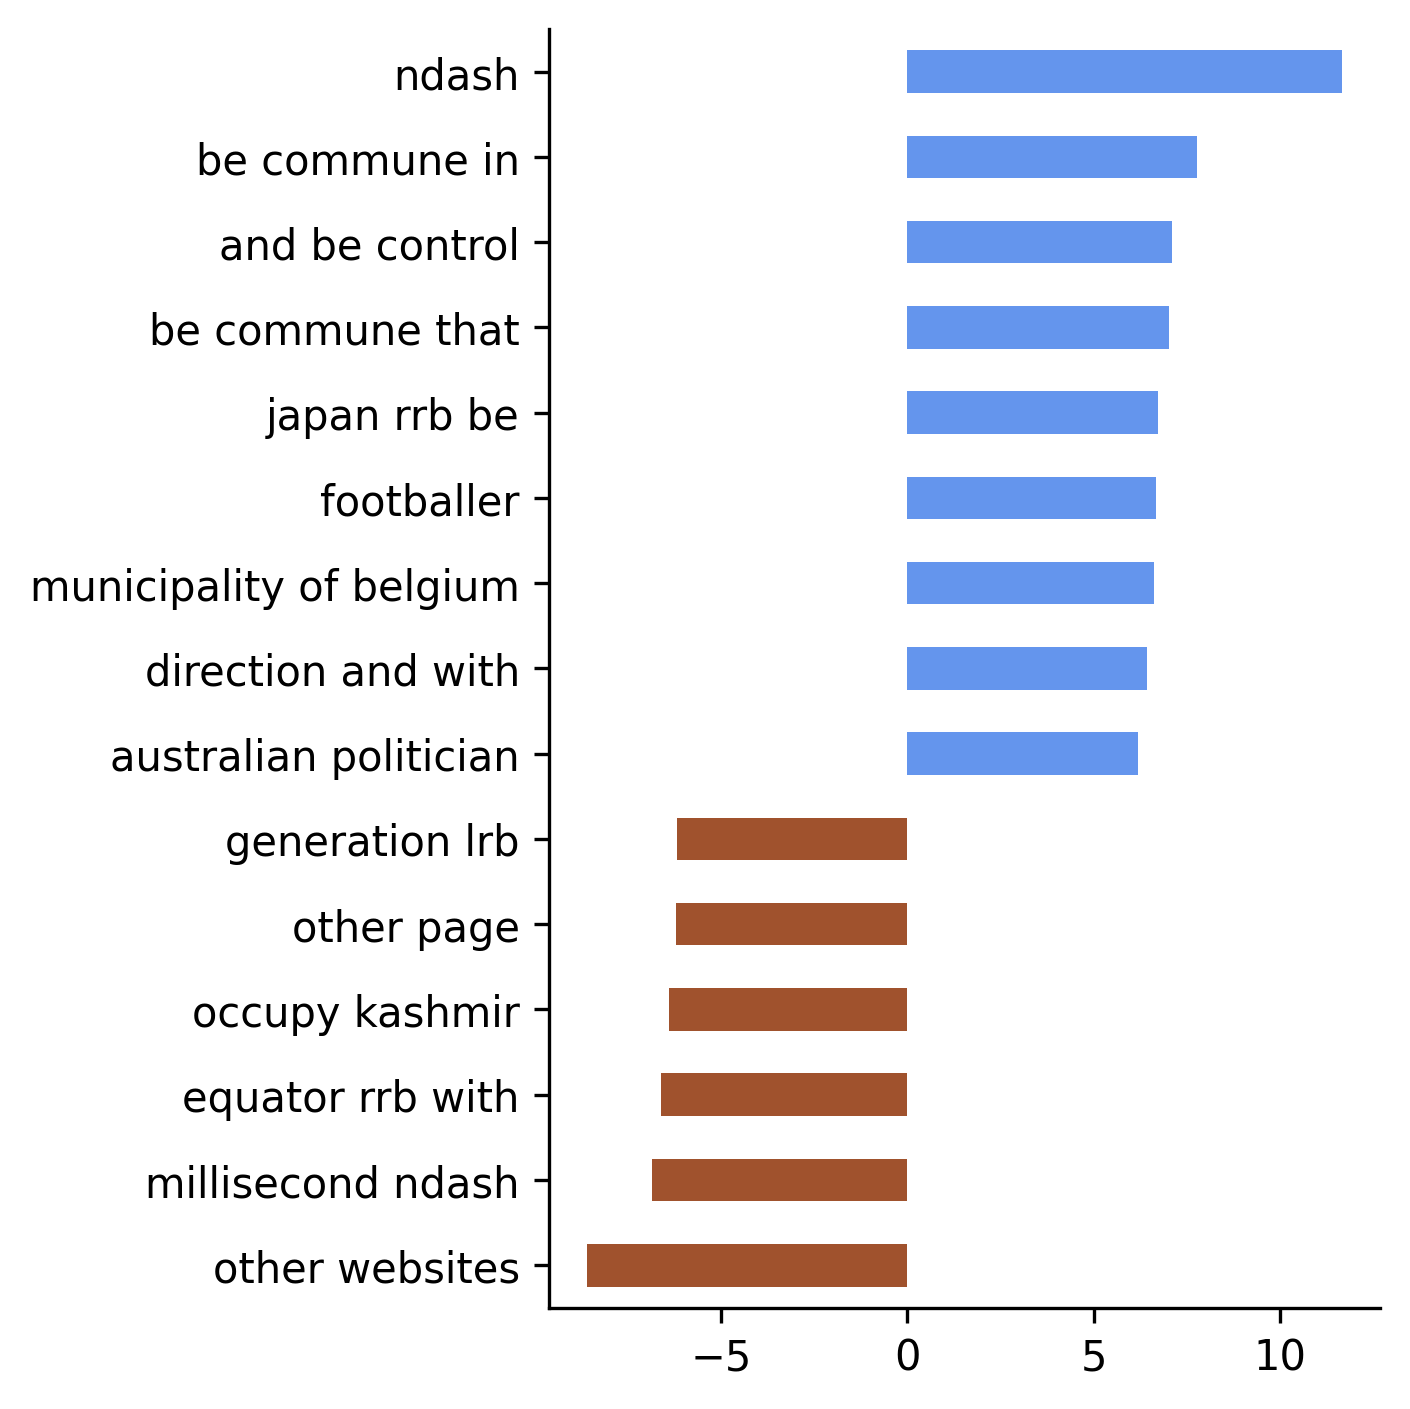

In [42]:
def plot_feature_importances(save=False):
  readability_features_trf = clf['preprocessor'].transformers_[0][1]['binner'].get_feature_names_out(readability_features)
  text_features_trf = clf['preprocessor'].transformers_[1][1].get_feature_names_out()
  all_features = list(readability_features_trf) + list(text_features_trf)

  plot_df = pd.DataFrame({'Feature':all_features, 
                          'Coefficient':clf[-1].coef_[0], 
                          'Absolute Coefficient':np.abs(clf[-1].coef_[0]),
                          'is_pos':(clf[-1].coef_[0] >= 0)})
  cmap = {True:'cornflowerblue', False:'sienna'}
  plot_df = plot_df.sort_values('Absolute Coefficient', ascending=False).head(15).sort_values('Coefficient')

  fig = plt.figure(dpi=300, figsize=(4.8, 4.8))
  ax = plt.gca()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plot_df.plot.barh('Feature', 
                    'Coefficient', 
                    legend=False, 
                    color=plot_df.is_pos.map(cmap), 
                    ax=ax)
  
  ax.set_ylabel(None)

  fig.tight_layout()
  if save:
    plt.savefig(''.join([repo_path, 'svm-feature-imporances.png']), format='png')

plot_feature_importances(True)